In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

slim = tf.contrib.slim

/Users/shatapy/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_train = np.asarray(x_train, np.float32)
x_train = np.reshape(x_train, [-1, 784])

x_test = x_test / 255.
x_test = np.asarray(x_test, np.float32)
x_test = np.reshape(x_test, [-1, 784])

In [4]:
batch_size = 64

tr_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tr_dataset = tr_dataset.shuffle(10000)
tr_dataset = tr_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = test_dataset.shuffle(10000)
test_dataset = test_dataset.batch(batch_size)

In [5]:
is_training = tf.placeholder(tf.bool)
handle = tf.placeholder(tf.string)
iterator = tf.data.Iterator.from_string_handle(handle,
                           tr_dataset.output_types,
                           tr_dataset.output_shapes)

x, y = iterator.get_next()

In [6]:
n_en_h1, n_en_h2, n_en_h3 = 128, 64, 16
n_code = 2
n_de_h1, n_de_h2, n_de_h3 = 16, 64, 128

In [7]:
def layer(x, weight_shape, bias_shape):
    W = tf.get_variable('W', weight_shape, initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b', bias_shape, initializer=tf.zeros_initializer())
    logit = tf.matmul(x, W) + b
    logit = slim.batch_norm(logit, activation_fn=tf.nn.relu, is_training=is_training)
    return logit

In [8]:
def encoder(x):
    with tf.variable_scope('encoder'):
        with tf.variable_scope('hidden1'):
            h1 = layer(x, [x.shape[-1], n_en_h1], [n_en_h1])
        with tf.variable_scope('hidden2'):
            h2 = layer(h1, [n_en_h1, n_en_h2], [n_en_h2])
        with tf.variable_scope('hidden3'):
            h3 = layer(h2, [n_en_h2, n_en_h3], [n_en_h3])
        with tf.variable_scope('output'):
            output = layer(h3, [n_en_h3, n_code], [n_code])
    
    return output

In [9]:
def decoder(x):
    with tf.variable_scope('decoder'):
        with tf.variable_scope('hidden1'):
            h1 = layer(x, [n_code, n_de_h1], [n_de_h1])
        with tf.variable_scope('hidden2'):
            h2 = layer(h1, [n_de_h1, n_de_h2], [n_de_h2])
        with tf.variable_scope('hidden3'):
            h3 = layer(h2, [n_de_h2, n_de_h3], [n_de_h3])
        with tf.variable_scope('output'):
            output = layer(h3, [n_de_h3, 784], [784])
    
    return output

In [10]:
encoder = encoder(x)
output = decoder(encoder)

In [11]:
loss = tf.losses.mean_squared_error(labels=x, predictions=output)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.AdamOptimizer(0.002, beta1=0.9, beta2=0.999, epsilon=1e-8).minimize(loss)

In [12]:
graph_dir = 'checkpoints'
print('Saving graph to: %s' % graph_dir)
train_writer = tf.summary.FileWriter(graph_dir)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: checkpoints


In [13]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss/mse', loss)
    summary_op = tf.summary.merge_all()

In [14]:
saver = tf.train.Saver()

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_iterator = tr_dataset.make_initializable_iterator()
train_handle = sess.run(train_iterator.string_handle())

n_epoch = 25
step = 0

for epoch in range(n_epoch):
    sess.run(train_iterator.initializer)
    
    print('Epoch: ', epoch)
    
    while True:
        try:
            _, loss_ = sess.run([train_op, loss], 
                                feed_dict={handle: train_handle, is_training: True})
            
            if step % 100 == 0:
                print('Step: {}, loss: {}'.format(step, loss_))
                
                summary_str = sess.run(summary_op, 
                                       feed_dict={handle: train_handle, is_training: False})
                train_writer.add_summary(summary_str, global_step=step)
                
            step += 1
                
        except tf.errors.OutOfRangeError:
            print('end of dataset')
            break
    
    if epoch % 5 == 0:
        print('Saving the model')
        saver.save(sess, './checkpoints/model.ckpt', global_step=step)


train_writer.close()
print('TRAINING DONE!')

Epoch:  0
Step: 0, loss: 0.525895893573761
Saving the model
Step: 100, loss: 0.07021825015544891
Step: 200, loss: 0.06675320863723755
Step: 300, loss: 0.07302774488925934
Step: 400, loss: 0.05762143060564995
Step: 500, loss: 0.06593289971351624
Step: 600, loss: 0.07673569023609161
Step: 700, loss: 0.057083792984485626
Step: 800, loss: 0.05283091962337494
Step: 900, loss: 0.05594160780310631
end of dataset
Epoch:  1
Step: 1000, loss: 0.05062258988618851
Saving the model
Step: 1100, loss: 0.05126475915312767
Step: 1200, loss: 0.051621098071336746
Step: 1300, loss: 0.04961712658405304
Step: 1400, loss: 0.049549929797649384
Step: 1500, loss: 0.05140145868062973
Step: 1600, loss: 0.046589646488428116
Step: 1700, loss: 0.04405643418431282
Step: 1800, loss: 0.046121157705783844
end of dataset
Epoch:  2
Step: 1900, loss: 0.04959026724100113
Step: 2000, loss: 0.04842033237218857
Saving the model
Step: 2100, loss: 0.04870739206671715
Step: 2200, loss: 0.04993531480431557
Step: 2300, loss: 0.0487

Step: 18900, loss: 0.04340542480349541
Step: 19000, loss: 0.04119439050555229
Saving the model
Step: 19100, loss: 0.03786858171224594
Step: 19200, loss: 0.0408967062830925
Step: 19300, loss: 0.03515838086605072
Step: 19400, loss: 0.04289507493376732
Step: 19500, loss: 0.05775578320026398
end of dataset
Epoch:  21
Step: 19500, loss: 0.04447886347770691
Step: 19600, loss: 0.03950515016913414
Step: 19700, loss: 0.03802867978811264
Step: 19800, loss: 0.04166295751929283
Step: 19900, loss: 0.03881978616118431
Step: 20000, loss: 0.040186990052461624
Saving the model
Step: 20100, loss: 0.04210689291357994
Step: 20200, loss: 0.039337415248155594
Step: 20300, loss: 0.03868943825364113
Step: 20400, loss: 0.038931652903556824
end of dataset
Epoch:  22
Step: 20500, loss: 0.04191300645470619
Step: 20600, loss: 0.04032803699374199
Step: 20700, loss: 0.03927113488316536
Step: 20800, loss: 0.03835906460881233
Step: 20900, loss: 0.043910231441259384
Step: 21000, loss: 0.04118766263127327
Saving the mod

In [18]:
model_ckpt = tf.train.latest_checkpoint(graph_dir+'/model.ckpt')

In [19]:
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())

sess.run(test_iterator.initializer)

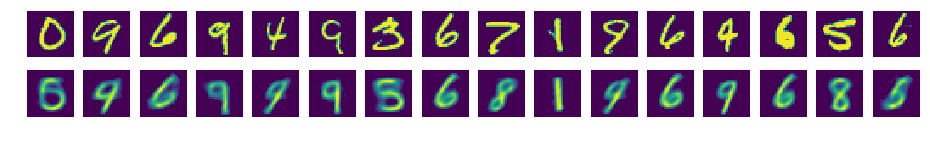

In [20]:
sample_size = 16
batch_idx = np.random.choice(len(x_test), sample_size, replace=False)
batch_xs = x_test[batch_idx]
y_pred = sess.run(output, feed_dict={x: batch_xs, is_training: False})

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(batch_xs[i], [28, 28]))
    ax[1][i].imshow(np.reshape(y_pred[i], [28, 28]))
